---
title: "2023_Kronensicherung_Plesse_Analyse"
author: "Kyell Jensen"
date: "2024-08-06"
format: pdf
editor: visual
---

# 2023_Kronensicherung_Plesse_Analyse

## Analyse der Schwingungsparameter

Nutze eine geeignete Python 3.11 Umgebung (z. B. virtuelle Environment).

## Arbeitsumgebung vorbereiten


### IMPORT: Packages

In [2]:
# Struktur & Typen
from pathlib import Path
from typing import Dict, List

# Datenverarbeitung
import json
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from slugify import slugify  # Zum Vereinheitlichen von Strings

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistik
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
# Eigene Module und Funktionen
from kj_core.utils.latex_export import (
    generate_latex_table,
    generate_grouped_latex_tables,
    save_latex_table,
    build_data_dict_df,
    grouped_describe
)
from kj_core.utils.labeling import (
    get_label_from_dict,
    get_color_dict
)
from kj_core import (
    CoreConfig,
    PlotManager,
    get_logger
)

# Projekteinstellungen
from project_config import (
    working_directory,
    data_export_directory,
    latex_export_directory,
    filename_clean_dataset,
    filename_clean_data_dict
)

### IMPORT: Manager Instanzen

In [4]:
logger = get_logger(__name__)
CONFIG = CoreConfig(working_directory=f"{working_directory}/combined")
PLOT_MANAGER = PlotManager(CONFIG)

2025-04-26 11:53:08 [WARNING] kj_core.core_config.set_working_directory: The directory C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined already exists.
2025-04-26 11:53:08 [INFO] kj_core.core_config.set_working_directory: Working directory set to C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined!
2025-04-26 11:53:08 [INFO] kj_core.core_config.__init__: <CoreConfig>
  Package:            kj_core
  Working Directory:  C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined
  Plot Directory:     C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined\plots
  Data Directory:     C:\kyellsen\005_Projekte\2024

## IMPORT: Daten Import

In [5]:
# Dateien laden
df = pd.read_feather(data_export_directory / filename_clean_dataset)

with open(data_export_directory / filename_clean_data_dict, "r", encoding="utf-8") as f:
    data_dict = json.load(f)

## ANALYSE: Explorative Datenanalyse

In [6]:
df.head(10)

,id,rope_datetime,treatment,release_force_target,rope_release,cable_max,sensor_name,location,direction,height,...,frequency_damped,phase_angle,y_shift,x_shift,frequency_undamped,damping_ratio,metrics_warning,pearson_r,nrmse,nmae
4,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(90),StB,elongation,16.55,...,0.441518,0.200000,-5.287164,0.116641,0.442936,0.503994,False,0.943158,0.038866,0.018011
5,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(92),StB,elongation,11.6,...,0.432441,-0.200000,-14.233644,-0.009730,0.436601,0.873595,False,0.929554,0.034560,0.016183
6,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(95),StA,elongation,11.6,...,0.422702,-0.200000,-19.011309,-0.123043,0.426319,0.823807,False,0.908058,0.044873,0.024274
7,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(98),StA,elongation,16.85,...,0.443529,-0.065967,-1.099515,0.118608,0.445993,0.663224,False,0.980663,0.029621,0.021087
8,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(90),StB,elongation,16.55,...,0.440653,0.200000,7.775284,0.097887,0.441317,0.344951,False,0.957380,0.043035,0.018619
9,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(92),StB,elongation,11.6,...,0.439321,-0.075771,7.052210,0.094719,0.441380,0.608931,False,0.933463,0.043534,0.021255
10,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(95),StA,elongation,11.6,...,0.436023,-0.200000,-3.785755,-0.075741,0.438127,0.618021,False,0.938307,0.039020,0.022498
11,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(98),StA,elongation,16.85,...,0.441350,-0.200000,-17.747289,-0.203345,0.442888,0.525070,False,0.974139,0.028693,0.020715
12,4,2022-03-23 11:54:33,free,2.8,2.73950,NaN,Elasto(90),StB,elongation,16.55,...,0.439065,0.200000,-23.445975,0.120929,0.439764,0.354677,False,0.945320,0.049764,0.021509
13,4,2022-03-23 11:54:33,free,2.8,2.73950,NaN,Elasto(92),StB,elongation,11.6,...,0.436850,-0.200000,-19.454720,0.061912,0.438829,0.598701,False,0.922665,0.050822,0.020659


In [7]:
df.columns

Index(['id', 'rope_datetime', 'treatment', 'release_force_target',
       'rope_release', 'cable_max', 'sensor_name', 'location', 'direction',
       'height', 'diameter', 'max_strain', 'max_compression', 'm_amplitude',
       'm_amplitude_2', 'initial_amplitude', 'damping_coeff',
       'frequency_damped', 'phase_angle', 'y_shift', 'x_shift',
       'frequency_undamped', 'damping_ratio', 'metrics_warning', 'pearson_r',
       'nrmse', 'nmae'],
      dtype='object')

### SET: Definition von Darstellungsstandards
Festlegen von Farbcodes für einheitliche Darstellung von Sensoren und Behandlungsvarianten für alle nachfolgenden Plots.

In [8]:
color_palette = PLOT_MANAGER.color_palette_list

# Für die Spalte "treatment":
treatment_color_dict = get_color_dict(df, "treatment", PLOT_MANAGER.color_palette_list)
# Für die Spalte "sensor_name":
sensor_color_dict = get_color_dict(df, "sensor_name", PLOT_MANAGER.color_palette_list)

Index(['free', 'gefa_dynamic', 'cobra_static'], dtype='object')
Index(['Elasto(90)', 'Elasto(92)', 'Elasto(95)', 'Elasto(98)'], dtype='object')


### LATEX-EXPORT: Latex-Export von Daten für Anhang

Exportiere Rohdaten der Schwingungsanalyse vollständig

In [9]:
variables = ['id', 'sensor_name', 'treatment', 'm_amplitude', 'm_amplitude_2', 'initial_amplitude', 'frequency_damped', 'frequency_undamped', 'damping_coeff', 'damping_ratio', 'y_shift', 'pearson_r', 'nmae']

# DataFrame kopieren und die gewünschten Spalten auswählen
df_latex = df.copy()[variables]

# Spaltennamen mit den Kurzbezeichnungen (Zeichen) aus dem data_dict umbenennen
df_latex = df_latex.rename(columns={var: data_dict[var]["Zeichen"] for var in variables})
# Funktionsaufruf mit Beispielparametern
generate_grouped_latex_tables(
    df_latex=df_latex,
    caption="Feldversuch 2 - Ergebnisse, Schwingungsparameter vollständig",
    column_format="lrl|rrr|rr|rr|r|rr",
    group_by="treatment",
    latex_export_directory=latex_export_directory
)

Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\feldversuch_2_ergebnisse_schwingungsparameter_vollstandig.tex


## SET: Definiere zu untersuchende Schwingungsparameter

In diesem Abschnitt werden die Schwingungsparameter statistisch ausgewertet. Ziel ist es, den Einfluss verschiedener Behandlungsvarianten (treatment) auf die gemessenen Schwingungsparameter zu untersuchen und dabei auch den potenziellen Einfluss der Vorspannung (rope_release) und Sensorposition (sensor_name) zu berücksichtigen.


In [10]:
variables = [
    'max_strain',
    'max_compression',
    'm_amplitude', 
    'm_amplitude_2',
    'initial_amplitude',
    'frequency_damped', 
    'frequency_undamped',
    'damping_coeff', 
    'damping_ratio', 
    #'phase_angle', 
    'y_shift', 
    #'x_shift',
    'pearson_r',
    #'nrmse', 
    'nmae'
]

add_variables = ["id", "treatment", "rope_release", "cable_max"]

## ANALYSE: Systematischer Einfluss der Sensorposition

Ziel: Visuell erkennen, ob unterschiedliche Sensoren konsistent andere Werte liefern.

In [11]:
# Plot erstellen
for i, var in enumerate(variables):
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="sensor_name", y=var, data=df, dodge=True)
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss der Sensoren auf {get_label_from_dict(var, data_dict, use_titel=True)}")
    plt.xlabel("Sensorname")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"sensor_effect_{i}_{var}", subdir="ptq_osc_sensor_effect_no_groups")

Ziel: Feststellen, ob die Variation durch unterschiedliche Sensorpostion relativ zur behandlungsbedingten Variation relevant ist.

In [12]:
# Plot erstellen
for i, var in enumerate(variables):
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="sensor_name", y=var, data=df, hue="treatment", palette=treatment_color_dict,  dodge=True)
    # Stripplot: Punkte zur Veranschaulichung der Verteilung
    sns.stripplot(x="sensor_name", y=var, data=df, hue="treatment", palette=treatment_color_dict, dodge=True, alpha=1, jitter=True, size=5, legend=False)
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss der Behandlung auf {get_label_from_dict(var, data_dict, use_titel=True)} gruppiert über Sensoren")
    plt.xlabel("Sensorname")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"sensor_effect_by_treatment_{i}_{var}", subdir="ptq_osc_sensor_effect_by_treatment")

Ziel: Feststellen, ob die Variation durch unterschiedliche Behandlungen relativ zur sensorbedingten Variation relevant ist.

In [13]:
# Plot erstellen
for i, var in enumerate(variables):
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="treatment", y=var, data=df, palette=sensor_color_dict, hue='sensor_name')
    sns.stripplot(x="treatment", y=var, data=df, palette=sensor_color_dict, hue='sensor_name', dodge=True, alpha=1, jitter=True, size=5, legend=False)
    plt.title(f"Einfluss der Sensoren auf {get_label_from_dict(var, data_dict, use_titel=True)} gruppiert über Behandlung")
    plt.xlabel("Behandlungsvariante")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"treatment_effect_by_sensor_{i}_{var}", subdir="ptq_osc_treatment_effect_by_sensor")

### ANALYSE: Effekt der Sensorposition innerhalb einer Beobachtung

In [14]:
# 1. Deskriptive Statistiken pro Sensor
summary_by_sensor = df.groupby('sensor_name', observed=False)[variables].describe()
summary_by_sensor

max_strain                                                       \
                 count        mean        std    min     25%    50%     75%   
sensor_name                                                                   
Elasto(90)        27.0  360.955556  35.985417  310.2  331.45  354.7  384.15   
Elasto(92)        27.0  232.140741  29.171644  184.6  212.15  228.3  245.20   
Elasto(95)        27.0  218.670370  28.335922  155.3  199.75  216.9  237.00   
Elasto(98)        27.0  181.800000  26.336214  128.9  163.50  184.8  198.80   

                   max_compression              ... pearson_r            nmae  \
               max           count        mean  ...       75%       max count   
sensor_name                                     ...                             
Elasto(90)   429.6            27.0 -149.022222  ...  0.954331  0.972302  27.0   
Elasto(92)   291.5            27.0  -50.892593  ...  0.929332  0.935316  27.0   
Elasto(95)   266.3            27.0  -50.437037  ...  0.922548  0.941718  27.0   
Elasto(98)   234.6            27.0 -123.570370  ...  0.975588  0.987644  27.0   

                                                                         \
                 mean       std       min       25%       50%       75%   
sensor_name                                                               
Elasto(90)   0.023165  0.009357  0.014277  0.018246  0.021509  0.025602   
Elasto(92)   0.029160  0.006568  0.016183  0.025229  0.028271  0.033684   
Elasto(95)   0.033910  0.007446  0.022498  0.029312  0.032552  0.037804   
Elasto(98)   0.030302  0.009289  0.019387  0.021929  0.028730  0.036272   

                       
                  max  
sensor_name            
Elasto(90)   0.062792  
Elasto(92)   0.041554  
Elasto(95)   0.050641  
Elasto(98)   0.054711  

[4 rows x 96 columns]

In [15]:
# 3. ANOVA: Teste, ob die Unterschiede zwischen den Sensoren signifikant sind
print("\nANOVA-Tests für Unterschiede zwischen den Sensoren:")
for var in variables:
    # Fit eines linearen Modells mit sensor_name als Prädiktor
    model = smf.ols(formula=f"{var} ~ C(sensor_name)", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nANOVA für {var}:")
    print(anova_table)


ANOVA-Tests für Unterschiede zwischen den Sensoren:

ANOVA für max_strain:
                       sum_sq     df           F        PR(>F)
C(sensor_name)  492818.234352    3.0  180.397796  4.550338e-41
Residual         94703.848148  104.0         NaN           NaN

ANOVA für max_compression:
                       sum_sq     df          F        PR(>F)
C(sensor_name)  206732.324722    3.0  50.247393  3.723270e-20
Residual        142628.704444  104.0        NaN           NaN

ANOVA für m_amplitude:
                       sum_sq     df           F        PR(>F)
C(sensor_name)  284912.661574    3.0  149.907389  1.270263e-37
Residual         65887.160926  104.0         NaN           NaN

ANOVA für m_amplitude_2:
                       sum_sq     df          F        PR(>F)
C(sensor_name)  145674.651736    3.0  79.526795  8.219855e-27
Residual         63501.296852  104.0        NaN           NaN

ANOVA für initial_amplitude:
                      sum_sq     df         F   PR(>F)
C(sensor_na

#### ANAYLSE: Optimaler Ansatz: Versuche Mixed-Linear Model

Die Daten sind hierarchisch: mehrere Messungen (vier Sensoren) pro Beobachtungseinheit (`id`). Ein Mixed-Effects Modell könnte diese Struktur abbilden, indem zufällige Effekte für `id` und feste Effekte für `treatment` sowie `sensor_name` berücksichtigt werden. Zusätzlich kann `rope_release` als Kovariate eingeführt werden. Dieser Ansatz wären theoretisch optimal, aber aufgrund der geringen Stichprobengröße und der komplexen Datenstruktur treten Konvergenzprobleme auf.

In [16]:
# Ergebnisse als Dictionary speichern
results_dict = {}

for var in variables:
    model = smf.mixedlm(
        f"{var} ~ C(treatment) + C(sensor_name) + rope_release", 
        data=df, 
        groups=df["id"]
    )
    result = model.fit()
    print(f"\n### Ergebnisse für {var}:")
    print(result.summary())
    print("\n")


### Ergebnisse für max_strain:
                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        max_strain
No. Observations:         108            Method:                    REML      
No. Groups:               27             Scale:                     353.4447  
Min. group size:          4              Log-Likelihood:            -461.3200 
Max. group size:          4              Converged:                 Yes       
Mean group size:          4.0                                                 
------------------------------------------------------------------------------
                              Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------
Intercept                     220.174   22.573   9.754 0.000  175.932  264.417
C(treatment)[T.gefa_dynamic]    5.177    7.113   0.728 0.467   -8.765   19.119
C(treatment)[T.cobra_static]  -13.986    

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



### Ergebnisse für m_amplitude:
                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        m_amplitude
No. Observations:        108            Method:                    REML       
No. Groups:              27             Scale:                     133.1670   
Min. group size:         4              Log-Likelihood:            -401.1554  
Max. group size:         4              Converged:                 Yes        
Mean group size:         4.0                                                  
------------------------------------------------------------------------------
                              Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------
Intercept                     176.658    8.767  20.150 0.000  159.475  193.842
C(treatment)[T.gefa_dynamic]  -22.842    2.722  -8.392 0.000  -28.177  -17.507
C(treatment)[T.cobra_static]  -44.541   

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t


### Ergebnisse für m_amplitude_2:
                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      m_amplitude_2
No. Observations:       108          Method:                  REML         
No. Groups:             27           Scale:                   180.6924     
Min. group size:        4            Log-Likelihood:          -416.5641    
Max. group size:        4            Converged:               No           
Mean group size:        4.0                                                
---------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                    126.698   10.211  12.408 0.000 106.685 146.711
C(treatment)[T.gefa_dynamic] -22.014    3.170  -6.944 0.000 -28.227 -15.801
C(treatment)[T.cobra_static] -49.446    3.170 -15.600 0.000 -55.659 -43.

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(



### Ergebnisse für initial_amplitude:
                  Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    initial_amplitude
No. Observations:      108        Method:                REML             
No. Groups:            27         Scale:                 107.1263         
Min. group size:       4          Log-Likelihood:        -392.0384        
Max. group size:       4          Converged:             Yes              
Mean group size:       4.0                                                
--------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                    172.562    8.499 20.304 0.000 155.904 189.220
C(treatment)[T.gefa_dynamic]   0.016    2.648  0.006 0.995  -5.174   5.207
C(treatment)[T.cobra_static]  -5.093    2.648 -1.924 0.054 -10.283   0.096
C(sen

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



### Ergebnisse für frequency_damped:
                 Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    frequency_damped
No. Observations:    108        Method:                REML            
No. Groups:          27         Scale:                 0.0010          
Min. group size:     4          Log-Likelihood:        196.7684        
Max. group size:     4          Converged:             Yes             
Mean group size:     4.0                                               
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.440    0.024 18.680 0.000  0.394  0.486
C(treatment)[T.gefa_dynamic]  0.013    0.007  1.826 0.068 -0.001  0.028
C(treatment)[T.cobra_static]  0.046    0.007  6.287 0.000  0.032  0.060
C(sensor_name)[T.Elasto(92)] -0.044    0.00

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t


### Ergebnisse für frequency_undamped:
                 Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   frequency_undamped
No. Observations:    108       Method:               REML              
No. Groups:          27        Scale:                0.0007            
Min. group size:     4         Log-Likelihood:       213.8221          
Max. group size:     4         Converged:            No                
Mean group size:     4.0                                               
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.437    0.020 21.963 0.000  0.398  0.476
C(treatment)[T.gefa_dynamic]  0.015    0.006  2.464 0.014  0.003  0.027
C(treatment)[T.cobra_static]  0.060    0.006  9.792 0.000  0.048  0.073
C(sensor_name)[T.Elasto(92)] -0.033    0.

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t


### Ergebnisse für damping_coeff:
                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     damping_coeff
No. Observations:     108         Method:                 REML         
No. Groups:           27          Scale:                  0.0137       
Min. group size:      4           Log-Likelihood:         62.4418      
Max. group size:      4           Converged:              No           
Mean group size:      4.0                                              
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.093    0.089  1.047 0.295 -0.081  0.268
C(treatment)[T.gefa_dynamic]  0.102    0.028  3.681 0.000  0.048  0.156
C(treatment)[T.cobra_static]  0.456    0.028 16.499 0.000  0.402  0.510
C(sensor_name)[T.Elasto(92)]  0.327    0.032 1

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



### Ergebnisse für damping_ratio:
                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     damping_ratio
No. Observations:     108         Method:                 REML         
No. Groups:           27          Scale:                  0.1134       
Min. group size:      4           Log-Likelihood:         -44.2139     
Max. group size:      4           Converged:              Yes          
Mean group size:      4.0                                              
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.183    0.256  0.717 0.474 -0.318  0.685
C(treatment)[T.gefa_dynamic]  0.209    0.079  2.632 0.008  0.053  0.365
C(treatment)[T.cobra_static]  0.988    0.079 12.443 0.000  0.833  1.144
C(sensor_name)[T.Elasto(92)]  0.869    0.092  

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Um dennoch aussagekräftige Ergebnisse zu erhalten, wird ein zweistufiges Verfahren genutzt.
Zwei Varianten:
- Mittlung über alle Sensoren innerhalb eine Beobachtung. Die Variation zwischen den Sensoren bleibt unberücksichtigt und verfälscht ggf. die Ergebnisse. Vorteil: Sehr einfach und stabil
- Werte um Sensor-Effekt manuell adjustieren und dann aggregieren wie zuvor. Vorteile: Sensoren verfälschen nicht die Ergebnisse. Nachteil ist die höhere Komplexität und das die Gesamtvariation der Modell am ende verfälsch ist.

#### ANALYSE Alternative 1: Vereinfachtes Vorgehen durch Aggregation (Mittelwert)

In [17]:
df_mean = df.groupby("id").agg({var: "mean" for var in variables}).reset_index()
# Benenne die Spalten um, damit klar ist, dass es sich um Mittelwerte handelt.
df_mean = df_mean.rename(columns={var: f"{var}_mean" for var in variables})

# Füge zusätzliche Variablen (z.B. treatment und rope_release) hinzu.
treatment_df = df[["id", "treatment", "rope_release", "cable_max"]].drop_duplicates()
df_mean = df_mean.merge(treatment_df, on="id")
df_mean.describe()

,id,max_strain_mean,max_compression_mean,m_amplitude_mean,m_amplitude_2_mean,initial_amplitude_mean,frequency_damped_mean,frequency_undamped_mean,damping_coeff_mean,damping_ratio_mean,y_shift_mean,pearson_r_mean,nmae_mean,rope_release,cable_max
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,18.000000
mean,15.000000,248.391667,-93.480556,163.041667,84.181019,169.790250,0.456238,0.463587,0.434036,0.968812,-5.052978,0.888360,0.029134,2.371609,1.937778
std,7.937254,25.407331,31.077756,22.751519,21.178032,5.462118,0.022212,0.027848,0.200727,0.442173,11.351458,0.053055,0.006646,0.320477,0.799541
min,2.000000,204.125000,-144.950000,124.700000,50.825000,164.414861,0.435009,0.436606,0.218833,0.499237,-29.681988,0.799567,0.019889,1.946800,1.010000
25%,8.500000,232.437500,-125.262500,148.368750,61.868750,166.161477,0.437784,0.439283,0.276357,0.636314,-11.476625,0.842485,0.024730,2.012975,1.160000
50%,15.000000,244.750000,-80.800000,162.850000,87.362500,169.854061,0.450018,0.453386,0.336295,0.748273,-2.102457,0.894191,0.027968,2.356550,1.890000
75%,21.500000,262.400000,-73.425000,181.712500,102.618750,170.241598,0.466431,0.483996,0.692071,1.469274,1.091476,0.946130,0.033468,2.748225,2.717500
max,28.000000,297.150000,-43.775000,204.950000,115.737500,189.345841,0.508053,0.522475,0.748626,1.757161,15.637199,0.956986,0.043212,2.780700,3.090000


#### ANALYSE Alternative 2: Werte um Sensor-Effekt und Vorspannung Adjustieren und dann Aggregieren (Mittelwert)

In [18]:
model_dict = {}
# Erstelle eine Kopie des Original-DataFrames
df_copy = df.copy()

for var in variables:
    try:
        model = smf.ols(f"{var} ~ C(sensor_name)", data=df).fit()
        
        # Speichere das Modell im Dictionary (so hast du per Variable die komplette Summary)
        model_dict[var] = model
        # Berechne adjustierte Werte:
        # y_adj = y - (fitted effect - globaler Intercept)
        df_copy[f"{var}_adj"] = df_copy[var] - (model.fittedvalues - model.params['Intercept'])
    except Exception as e:
        print(f"Fehler bei {var}: {e}")

# Aggregiere über die ID – hier wird der Mittelwert der adjustierten Werte berechnet.
df_adj = df_copy.groupby("id").agg({f"{var}_adj": "mean" for var in variables}).reset_index()
# Ergänze zusätzliche Variablen (z.B. treatment und rope_release)
treatment_df = df[add_variables].drop_duplicates()
df_adj = df_adj.merge(treatment_df, on="id")

# Ausgabe der deskriptiven Statistik
df_adj.describe()

,id,max_strain_adj,max_compression_adj,m_amplitude_adj,m_amplitude_2_adj,initial_amplitude_adj,frequency_damped_adj,frequency_undamped_adj,damping_coeff_adj,damping_ratio_adj,y_shift_adj,pearson_r_adj,nmae_adj,rope_release,cable_max
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,18.000000
mean,15.000000,360.955556,-149.022222,251.248148,130.094444,175.130475,0.474489,0.476545,0.267204,0.553027,-8.353103,0.915106,0.023165,2.371609,1.937778
std,7.937254,25.407331,31.077756,22.751519,21.178032,5.462118,0.022212,0.027848,0.200727,0.442173,11.351458,0.053055,0.006646,0.320477,0.799541
min,2.000000,316.688889,-200.491667,212.906481,96.738426,169.755086,0.453260,0.449564,0.052001,0.083451,-32.982112,0.826312,0.013920,1.946800,1.010000
25%,8.500000,345.001389,-180.804167,236.575231,107.782176,171.501702,0.456035,0.452241,0.109524,0.220528,-14.776749,0.869231,0.018761,2.012975,1.160000
50%,15.000000,357.313889,-136.341667,251.056481,133.275926,175.194286,0.468269,0.466344,0.169462,0.332488,-5.402582,0.920936,0.021999,2.356550,1.890000
75%,21.500000,374.963889,-128.966667,269.918981,148.532176,175.581823,0.484681,0.496954,0.525238,1.053488,-2.208649,0.972875,0.027499,2.748225,2.717500
max,28.000000,409.713889,-99.316667,293.156481,161.650926,194.686066,0.526304,0.535433,0.581793,1.341375,12.337075,0.983732,0.037243,2.780700,3.090000


##### LATEX-EXPORT: Modell-Info

In [19]:
def extract_model_info(model):
    """
    Extrahiert zentrale Kennzahlen aus einem OLS-Modell.
    Liefert ein Dictionary mit R-squared, Adj. R-squared, sowie den Koeffizienten,
    Standardfehler, t-Werten und p-Werten für alle Parameter.
    """
    info = {
        "R²": model.rsquared,
        "adj_R²": model.rsquared_adj,
    }
    # Iteriere über alle Parameter im Modell
    for param in model.params.index:
        info[f"coef_{param}"] = model.params[param]
        info[f"std_err_{param}"] = model.bse[param]
        info[f"t_{param}"] = model.tvalues[param]
        info[f"p_{param}"] = model.pvalues[param]
    return info

In [20]:
# Erstelle eine Liste, in der pro Variable das extrahierte Dictionary gespeichert wird.
model_info_list = []
for var, model in model_dict.items():
    info = extract_model_info(model)
    info['variable'] = var  # Variable als Kennung hinzufügen
    model_info_list.append(info)

# Konvertiere die Liste in einen DataFrame und setze "variable" als Index
df_model_info = pd.DataFrame(model_info_list).set_index("variable")
df_model_info.index.name = "Statistik"
df_model_info = df_model_info.T

In [21]:
def format_value(x):
    # Prüfe, ob der Wert numerisch ist
    if isinstance(x, (int, float, np.number)):
        if abs(x) < 0.0001:
            return f"{x:.2e}"
        else:
            return f"{x:.2f}"
    return x

# Wende die Funktion auf alle Zellen von df_model_info an
df_model_info = df_model_info.applymap(format_value)
df_model_info

C:\Users\mail\AppData\Local\Temp\ipykernel_11024\3004503431.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_model_info = df_model_info.applymap(format_value)


Statistik,max_strain,max_compression,m_amplitude,m_amplitude_2,initial_amplitude,frequency_damped,frequency_undamped,damping_coeff,damping_ratio,y_shift,pearson_r,nmae
R²,0.84,0.59,0.81,0.70,0.09,0.23,0.14,0.30,0.34,0.05,0.27,0.19
adj_R²,0.83,0.58,0.81,0.69,0.06,0.20,0.11,0.28,0.32,0.02,0.24,0.16
coef_Intercept,360.96,-149.02,251.25,130.09,175.13,0.47,0.48,0.27,0.55,-8.35,0.92,0.02
std_err_Intercept,5.81,7.13,4.84,4.76,2.05,0.01,0.01,0.04,0.11,3.06,0.01,0.00
t_Intercept,62.15,-20.91,51.87,27.36,85.27,67.74,67.27,6.03,5.26,-2.73,63.71,14.59
p_Intercept,4.60e-84,4.88e-39,3.80e-76,2.58e-49,4.54e-98,7.39e-88,1.50e-87,2.49e-08,7.60e-07,0.01,3.77e-85,6.70e-27
coef_C(sensor_name)[T.Elasto(92)],-128.81,98.13,-114.62,-85.97,-8.36,-0.04,-0.03,0.33,0.87,0.81,-0.07,0.01
std_err_C(sensor_name)[T.Elasto(92)],8.21,10.08,6.85,6.73,2.90,0.01,0.01,0.06,0.15,4.33,0.02,0.00
t_C(sensor_name)[T.Elasto(92)],-15.68,9.74,-16.73,-12.78,-2.88,-4.48,-3.32,5.22,5.85,0.19,-3.48,2.67
p_C(sensor_name)[T.Elasto(92)],3.64e-29,2.62e-16,2.89e-31,4.67e-23,0.00,1.90e-05,0.00,9.25e-07,5.80e-08,0.85,0.00,0.01


In [22]:
# Manuelles Escapen der Unterstriche im Index
df_model_info.index = df_model_info.index.astype(str).str.replace('(sensor_name)[T.', r'(sensor)[')
df_model_info.index = df_model_info.index.astype(str).str.replace('_', r'\_')


# Spaltennamen mit den Kurzbezeichnungen (Zeichen) aus dem data_dict umbenennen
df_model_info = df_model_info.rename(columns={var: data_dict[var]["Zeichen"] for var in variables})

column_format = "l" + "r" * (len(df_model_info.columns))
latex_string = df_model_info.to_latex(index=True, escape=False, float_format="%.2f", column_format=column_format)

# Definiere Beschriftung und lange Beschriftung (Caption)
caption = "Feldversuch 2: Ergebnisse, Zusammenfassung der OLS-Modelle"
caption_long = "Übersicht über zentrale Kennzahlen der OLS-Modelle: R², Adjusted R², Koeffizienten, Standardfehler, t-Werte und p-Werte für alle Parameter."

# Funktion zum Speichern der LaTeX-Tabelle (du passt diese Funktion ggf. an deine Gegebenheiten an)
save_latex_table(latex_string, caption, latex_export_directory, caption_long)

Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\feldversuch_2_ergebnisse_zusammenfassung_der_ols_modelle.tex


#### Zusammenführen beider Alternativen für Vergleich

In [23]:
# --- Zusammenführen beider Ansätze ---
# Beide DataFrames enthalten nun jeweils den Mittelwert pro ID:
# - df_mean: direkte Mittelwerte mit Suffix _mean
# - df_adj: sensor-adjustierte Mittelwerte mit Suffix _adj
grouped_df = pd.merge(df_mean, df_adj, on=add_variables, how="inner")
grouped_df

,id,max_strain_mean,max_compression_mean,m_amplitude_mean,m_amplitude_2_mean,initial_amplitude_mean,frequency_damped_mean,frequency_undamped_mean,damping_coeff_mean,damping_ratio_mean,...,m_amplitude_adj,m_amplitude_2_adj,initial_amplitude_adj,frequency_damped_adj,frequency_undamped_adj,damping_coeff_adj,damping_ratio_adj,y_shift_adj,pearson_r_adj,nmae_adj
0,2,293.625,-124.350,198.6125,103.9750,169.960362,0.435047,0.437962,0.310671,0.716155,...,286.818981,149.888426,175.300587,0.453298,0.450920,0.143838,0.300369,-13.208032,0.967104,0.013920
1,3,293.800,-128.225,204.9500,115.1000,170.248463,0.439337,0.440928,0.230183,0.524243,...,293.156481,161.013426,175.588688,0.457588,0.453886,0.063350,0.108458,-4.976512,0.977568,0.014803
2,4,272.650,-136.150,199.6500,115.7375,170.814318,0.438575,0.440015,0.218833,0.499237,...,287.856481,161.650926,176.154543,0.456826,0.452973,0.052001,0.083451,-17.447255,0.974564,0.015818
3,5,267.575,-116.775,188.4000,108.7875,170.279813,0.435206,0.437687,0.284570,0.655074,...,276.606481,154.700926,175.620039,0.453457,0.450645,0.117738,0.239288,0.292713,0.973763,0.016810
4,6,229.975,-144.950,186.4250,110.7250,184.280012,0.436994,0.438551,0.228966,0.524325,...,274.631481,156.638426,189.620237,0.455245,0.451509,0.062134,0.108539,-29.185826,0.983732,0.014754
5,7,251.300,-144.325,188.6250,111.0500,166.418673,0.436914,0.438531,0.230392,0.527382,...,276.831481,156.963426,171.758898,0.455165,0.451489,0.063559,0.111597,-27.920077,0.981784,0.019778
6,8,215.500,-126.325,168.9625,102.7000,170.546205,0.435009,0.436606,0.226999,0.522647,...,257.168981,148.613426,175.886430,0.453260,0.449564,0.060166,0.106862,-16.719105,0.981424,0.017783
7,9,221.200,-126.175,165.8375,102.5375,170.234733,0.435197,0.437420,0.268143,0.617555,...,254.043981,148.450926,175.574958,0.453448,0.450378,0.101311,0.201769,-16.345466,0.971988,0.021725
8,10,209.275,-130.575,163.3000,100.0625,170.351945,0.435257,0.436960,0.235773,0.542241,...,251.506481,145.975926,175.692170,0.453508,0.449918,0.068940,0.126455,-24.099727,0.982202,0.017395
9,11,247.825,-120.625,177.0625,94.5000,189.345841,0.455380,0.458899,0.351440,0.773543,...,265.268981,140.413426,194.686066,0.473630,0.471857,0.184608,0.357757,-32.982112,0.928857,0.020250


#### VISUALISIERUNG: Stelle beide Methoden der Aggregation gegenüber

In [26]:
for i, var in enumerate(variables):
    # Transformiere die Daten in das Long-Format: 
    # Es werden die beiden Spalten f"{var}_mean" und f"{var}_adj" unter einer neuen Spalte "aggregation" zusammengeführt,
    # und die Werte in der Spalte "value" gespeichert.
    df_long = pd.melt(
        grouped_df,
        id_vars=["id", "treatment", "rope_release"],
        value_vars=[f"{var}_mean", f"{var}_adj"],
        var_name="aggregation",
        value_name="value"
    )
    # Kürze die Beschriftungen, sodass nur "mean" bzw. "adj" übrig bleiben
    df_long["aggregation"] = df_long["aggregation"].str.replace(f"{var}_", "", regex=False)
    
    # Erstelle den Plot: Boxplots nach Behandlung, getrennt nach Aggregationsmethode
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="treatment", y="value", hue="aggregation", data=df_long, dodge=True)
    
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss der Behandlung auf {get_label_from_dict(var, data_dict, use_titel=True)}")
    plt.xlabel("Behandlung")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    
    # Speichere den Plot (ersetze PLOT_MANAGER.save_plot durch plt.show() oder deine eigene Funktion, falls nötig)
    PLOT_MANAGER.save_plot(fig, filename=f"effect_treatment_{i}_{var}", subdir="ptq_osc_sensor_effect_4_comparision_mean_vs_adj")

#### SET: Übernimm um Sensorposition adjustierte Werte

Die statistische Bereinigung um den Effekt der Sensoren erscheint geeigneter, die daten werden nachfolgend weiter verwendet

In [27]:
df_adj

,id,max_strain_adj,max_compression_adj,m_amplitude_adj,m_amplitude_2_adj,initial_amplitude_adj,frequency_damped_adj,frequency_undamped_adj,damping_coeff_adj,damping_ratio_adj,y_shift_adj,pearson_r_adj,nmae_adj,treatment,rope_release,cable_max
0,2,406.188889,-179.891667,286.818981,149.888426,175.300587,0.453298,0.450920,0.143838,0.300369,-13.208032,0.967104,0.013920,free,2.72310,NaN
1,3,406.363889,-183.766667,293.156481,161.013426,175.588688,0.457588,0.453886,0.063350,0.108458,-4.976512,0.977568,0.014803,free,2.76205,NaN
2,4,385.213889,-191.691667,287.856481,161.650926,176.154543,0.456826,0.452973,0.052001,0.083451,-17.447255,0.974564,0.015818,free,2.73950,NaN
3,5,380.138889,-172.316667,276.606481,154.700926,175.620039,0.453457,0.450645,0.117738,0.239288,0.292713,0.973763,0.016810,free,2.36475,NaN
4,6,342.538889,-200.491667,274.631481,156.638426,189.620237,0.455245,0.451509,0.062134,0.108539,-29.185826,0.983732,0.014754,free,2.38000,NaN
5,7,363.863889,-199.866667,276.831481,156.963426,171.758898,0.455165,0.451489,0.063559,0.111597,-27.920077,0.981784,0.019778,free,2.36920,NaN
6,8,328.063889,-181.866667,257.168981,148.613426,175.886430,0.453260,0.449564,0.060166,0.106862,-16.719105,0.981424,0.017783,free,1.96440,NaN
7,9,333.763889,-181.716667,254.043981,148.450926,175.574958,0.453448,0.450378,0.101311,0.201769,-16.345466,0.971988,0.021725,free,1.97830,NaN
8,10,321.838889,-186.116667,251.506481,145.975926,175.692170,0.453508,0.449918,0.068940,0.126455,-24.099727,0.982202,0.017395,free,1.94680,NaN
9,11,360.388889,-176.166667,265.268981,140.413426,194.686066,0.473630,0.471857,0.184608,0.357757,-32.982112,0.928857,0.020250,gefa_dynamic,2.75785,1.48


In [28]:
# 1. Alle "_adj"‑Suffixe aus den Spaltennamen entfernen
df_adj = df_adj.rename(columns=lambda x: x[:-4] if x.endswith("_adj") else x)

# 2. Gewünschte Spalten vorne in der Reihenfolge id, treatment, rope_release, cable_max
front = add_variables
# Alle übrigen Spalten, in der vorhandenen Reihenfolge
rest = [c for c in df_adj.columns if c not in front]

# 3. DataFrame umsortieren
df_adj = df_adj[front + rest]
df_adj

,id,treatment,rope_release,cable_max,max_strain,max_compression,m_amplitude,m_amplitude_2,initial_amplitude,frequency_damped,frequency_undamped,damping_coeff,damping_ratio,y_shift,pearson_r,nmae
0,2,free,2.72310,NaN,406.188889,-179.891667,286.818981,149.888426,175.300587,0.453298,0.450920,0.143838,0.300369,-13.208032,0.967104,0.013920
1,3,free,2.76205,NaN,406.363889,-183.766667,293.156481,161.013426,175.588688,0.457588,0.453886,0.063350,0.108458,-4.976512,0.977568,0.014803
2,4,free,2.73950,NaN,385.213889,-191.691667,287.856481,161.650926,176.154543,0.456826,0.452973,0.052001,0.083451,-17.447255,0.974564,0.015818
3,5,free,2.36475,NaN,380.138889,-172.316667,276.606481,154.700926,175.620039,0.453457,0.450645,0.117738,0.239288,0.292713,0.973763,0.016810
4,6,free,2.38000,NaN,342.538889,-200.491667,274.631481,156.638426,189.620237,0.455245,0.451509,0.062134,0.108539,-29.185826,0.983732,0.014754
5,7,free,2.36920,NaN,363.863889,-199.866667,276.831481,156.963426,171.758898,0.455165,0.451489,0.063559,0.111597,-27.920077,0.981784,0.019778
6,8,free,1.96440,NaN,328.063889,-181.866667,257.168981,148.613426,175.886430,0.453260,0.449564,0.060166,0.106862,-16.719105,0.981424,0.017783
7,9,free,1.97830,NaN,333.763889,-181.716667,254.043981,148.450926,175.574958,0.453448,0.450378,0.101311,0.201769,-16.345466,0.971988,0.021725
8,10,free,1.94680,NaN,321.838889,-186.116667,251.506481,145.975926,175.692170,0.453508,0.449918,0.068940,0.126455,-24.099727,0.982202,0.017395
9,11,gefa_dynamic,2.75785,1.48,360.388889,-176.166667,265.268981,140.413426,194.686066,0.473630,0.471857,0.184608,0.357757,-32.982112,0.928857,0.020250


## EXPORT: Für CHAT-GPT exportieren


In [29]:
df_adj.to_csv(data_export_directory / "_dataset_df_adj.csv", sep=";", index=True, encoding="utf-8")

## ANALYSE: Systematischer Einfluss der Behandlungsvariante auf Schwingungsparameter

In [ ]:
# Ausgewählte Zielvariablen
variables = [
    'max_strain','max_compression','m_amplitude','m_amplitude_2',
    'initial_amplitude','frequency_damped','frequency_undamped',
    'damping_coeff','damping_ratio','y_shift','pearson_r','nmae'
]

### ANALYSE: Deskriptive Statistik

In [34]:
df_adf_desc = df_adj.groupby("treatment", observed=True).describe()
df_adf_desc

id                                               rope_release  \
             count  mean       std   min   25%   50%   75%   max        count   
treatment                                                                       
free           9.0   6.0  2.738613   2.0   4.0   6.0   8.0  10.0          9.0   
gefa_dynamic   9.0  15.0  2.738613  11.0  13.0  15.0  17.0  19.0          9.0   
cobra_static   9.0  24.0  2.738613  20.0  22.0  24.0  26.0  28.0          9.0   

                        ... pearson_r            nmae                      \
                  mean  ...       75%       max count      mean       std   
treatment               ...                                                 
free          2.358678  ...  0.981784  0.983732   9.0  0.016976  0.002540   
gefa_dynamic  2.379867  ...  0.926223  0.933683   9.0  0.027948  0.007054   
cobra_static  2.376283  ...  0.872100  0.911033   9.0  0.024571  0.004037   

                                                                
                   min       25%       50%       75%       max  
treatment                                                       
free          0.013920  0.014803  0.016810  0.017783  0.021725  
gefa_dynamic  0.020250  0.022027  0.024465  0.036438  0.037243  
cobra_static  0.019739  0.021561  0.023650  0.027672  0.030218  

[3 rows x 120 columns]

Es sind Unterschiede erkennbar je nach Gruppe, weitere Auswertung

### VISUALISIERUNG: Explorative Visualisierung

In [37]:
# Plot erstellen
for i, var in enumerate(variables):
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_adj, x="treatment", y=var, hue="treatment")
    
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss der Behandlung auf {get_label_from_dict(var, data_dict, use_titel=True)}")
    plt.xlabel("Behandlungsvariante")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"treatment_effect_{i}_{var}", subdir="ptq_osc_treatment_effect_sensor_adj")

### ANALYSE: Statistische Auswertung ANCOVA

In [38]:
models = {}
for var in variables:
    formula = f"{var} ~ C(treatment) + rope_release"
    model = smf.ols(formula, data=df_adj).fit()
    models[var] = model
    print(f"Modell für {var} angepasst.")

Modell für max_strain angepasst.
Modell für max_compression angepasst.
Modell für m_amplitude angepasst.
Modell für m_amplitude_2 angepasst.
Modell für initial_amplitude angepasst.
Modell für frequency_damped angepasst.
Modell für frequency_undamped angepasst.
Modell für damping_coeff angepasst.
Modell für damping_ratio angepasst.
Modell für y_shift angepasst.
Modell für pearson_r angepasst.
Modell für nmae angepasst.


### LATEX-EXPORT: Ergebnisse systematischer Einfluss der Behandlungsvariante

In [31]:
variables = ['m_amplitude', 'm_amplitude_2', 'initial_amplitude', 'frequency_damped', 'frequency_undamped', 'damping_coeff', 'damping_ratio', 'y_shift', 'pearson_r', 'nmae']

df_latex = grouped_describe(df_adj, group_by="treatment", cols=variables, include_overall=True)
print(df_latex)

                        m_amplitude  m_amplitude_2  initial_amplitude  \
treatment    Statistik                                                  
free         count         9.000000       9.000000           9.000000   
             mean        273.180093     153.766204         176.799617   
             std          15.491703       5.750713           4.985708   
             min         251.506481     145.975926         171.758898   
             25%         257.168981     148.613426         175.574958   
             50%         276.606481     154.700926         175.620039   
             75%         286.818981     156.963426         175.886430   
             max         293.156481     161.650926         189.620237   
gefa_dynamic count         9.000000       9.000000           9.000000   
             mean        251.205093     131.995370         176.854008   
             std          14.644771       5.804666           6.897042   
             min         231.343981     120.300926 

In [32]:
# Optional: Spaltennamen gemäß data_dict umbenennen (nur, falls die Variable im data_dict existiert)
df_latex.rename(columns={var: data_dict[var]["Zeichen"] for var in variables if var in data_dict}, inplace=True)

df_latex.rename_axis(index={"treatment": "Behandlung"}, inplace=True)

# Entferne "%" aus der "Statistik"-Ebene des MultiIndex mittels pandas' str.replace
df_latex.index = df_latex.index.set_levels(
    df_latex.index.levels[1].str.replace('%', '\%'), 
    level="Statistik"
)

# Entferne "%" aus der "Statistik"-Ebene des MultiIndex mittels pandas' str.replace
df_latex.index = df_latex.index.set_levels(
    df_latex.index.levels[0].str.replace('_', '\_'), 
    level="Behandlung"
)

# Konvertierung des DataFrames mit Multi-Index-Spalten in einen LaTeX-String
latex_string = df_latex.to_latex(
    index=True,
    escape=False,
    float_format="{:0.2f}".format,
    multicolumn=True,
    multicolumn_format="c",
    column_format="ll|rrr|rr|rr|r|rr"
)

# Definition der Beschriftung für die LaTeX-Tabelle
caption = "Feldversuch 2 - Ergebnisse, Statistische Zusammenfassung, Schwingungsparameter und Anpassungsqualität adjustiert"
caption_long = "Feldversuch 2 - Ergebnisse, Statistische Zusammenfassung, Schwingungsparameter und Anpassungsqualität adjustiert"
save_latex_table(latex_string, caption, latex_export_directory, caption_long)

Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\feldversuch_2_ergebnisse_statistische_zusammenfassung_schwingungsparameter_und_anpassungsqualitat_adjustiert.tex


In [98]:
# Ergebnis‑Series für jede Variable sammeln
dfs = []
for var in variables:
    # 1) Modell fitten
    model = smf.ols(f"{var} ~ C(treatment)", data=df_adj).fit()
    # 2) ANOVA‑Tabelle holen
    aov = sm.stats.anova_lm(model, typ=2)
    
    # 3) Werte extrahieren
    ss_bt = aov.at["C(treatment)", "sum_sq"]
    df_bt = aov.at["C(treatment)", "df"]
    F    = aov.at["C(treatment)", "F"]
    p    = aov.at["C(treatment)", "PR(>F)"]
    
    ss_wt = aov.at["Residual", "sum_sq"]
    df_wt = aov.at["Residual", "df"]
    
    # 4) Mean Square und Effektstärke berechnen
    ms_bt  = ss_bt  / df_bt
    eta_sq = ss_bt / (ss_bt + ss_wt)
    
    # 5) in eine Series packen
    s = pd.Series({
        "df_between": df_bt,
        "df_within":  df_wt,
        "SS_between": ss_bt,
        "SS_within":  ss_wt,
        "MS_between": ms_bt,
        "F_stat":     F,
        "p_value":    p,
        "eta_sq":     eta_sq
    }, name=var)
    
    dfs.append(s)

# 6) alle Series zu einem DataFrame zusammenfügen
anova_results = (
    pd.concat(dfs, axis=1)
      .T
      .reset_index()
      .rename(columns={"index": "Variable"})
      #.sort_values("p_value")
      .reset_index(drop=True)
)

print(anova_results)

              Variable  df_between  df_within    SS_between    SS_within  \
0           max_strain         2.0       24.0   1768.936202  5233.357493   
1      max_compression         2.0       24.0  21041.351449  3599.821355   
2          m_amplitude         2.0       24.0   8920.079497   354.079475   
3        m_amplitude_2         2.0       24.0  11036.000828   353.662363   
4    initial_amplitude         2.0       24.0    155.401663   620.301495   
5     frequency_damped         2.0       24.0      0.010091     0.002736   
6   frequency_undamped         2.0       24.0      0.017827     0.002336   
7        damping_coeff         2.0       24.0      1.029987     0.017592   
8        damping_ratio         2.0       24.0      4.880654     0.202788   
9              y_shift         2.0       24.0    926.977686  2423.267813   
10           pearson_r         2.0       24.0      0.058470     0.014716   
11                nmae         2.0       24.0      0.000568     0.000580   

      MS_be

In [113]:
for i, var in enumerate(variables):
    print(f"\n=== Variable {i}: {var} ===")
    
    model = smf.ols(f"{var} ~ C(treatment)", data=df_adj).fit()
    # 2) Q‑Q‑Plot erzeugen
    fig = sm.qqplot(model.resid, line="45")
    # Speichern statt show
    PLOT_MANAGER.save_plot(fig, filename=f"treatment_effect_qq_{i}_{var}", subdir="ptq_osc_treatment_effect_sensor_adj_qq"
    )
    
    # 3) Shapiro‑Wilk auf die Residuen
    w_shapiro, p_shapiro = st.shapiro(model.resid)
    print(f"Shapiro‑Wilk: W = {w_shapiro:.4f}, p = {p_shapiro:.4f}")

    # 4) Levene‑Test auf Varianzhomogenität
    # Gruppen aus df_adj nach treatment extrahieren
    groups = [
        grp[var].values
        for _, grp in df_adj.groupby("treatment", sort=False, observed=False)
    ]
    w_levene, p_levene = st.levene(*groups)
    print(f"Levene   : W = {w_levene:.4f}, p = {p_levene:.4f}")



=== Variable 0: max_strain ===
Shapiro‑Wilk: W = 0.9589, p = 0.3484
Levene   : W = 0.3655, p = 0.6976

=== Variable 1: max_compression ===
Shapiro‑Wilk: W = 0.9798, p = 0.8584
Levene   : W = 0.2323, p = 0.7945

=== Variable 2: m_amplitude ===
Shapiro‑Wilk: W = 0.9577, p = 0.3280
Levene   : W = 0.0758, p = 0.9273

=== Variable 3: m_amplitude_2 ===
Shapiro‑Wilk: W = 0.8943, p = 0.0099
Levene   : W = 0.0551, p = 0.9465

=== Variable 4: initial_amplitude ===
Shapiro‑Wilk: W = 0.6259, p = 0.0000
Levene   : W = 0.1203, p = 0.8872

=== Variable 5: frequency_damped ===
Shapiro‑Wilk: W = 0.9111, p = 0.0242
Levene   : W = 14.4175, p = 0.0001

=== Variable 6: frequency_undamped ===
Shapiro‑Wilk: W = 0.9091, p = 0.0218
Levene   : W = 14.7422, p = 0.0001

=== Variable 7: damping_coeff ===
Shapiro‑Wilk: W = 0.9089, p = 0.0215
Levene   : W = 0.2728, p = 0.7636

=== Variable 8: damping_ratio ===
Shapiro‑Wilk: W = 0.9299, p = 0.0687
Levene   : W = 1.7240, p = 0.1997

=== Variable 9: y_shift ===
Shapir

### ANALYSE: Post-Hoc, Unterschiede der Behandlungsvarianten

Festzustellen welche paarweisen Unterschiede zwischen den Treatments signifikant sind.

In [116]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Dict für alle Tukey‑Resultate
tukey_dict = {}

for var in variables:
    # Tukey HSD fahren
    tuk = pairwise_tukeyhsd(
        endog=df_adj[var],
        groups=df_adj['treatment'],
        alpha=0.05
    )
    
    print(f"--- Post-Hoc Test (Tukey HSD) für Variable: {var} ---")
    print(tuk.summary())
    print("\n")
    
    # ins Dict packen
    tukey_dict[var] = tuk


--- Post-Hoc Test (Tukey HSD) für Variable: max_strain ---
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------
cobra_static         free   13.985 0.1317  -3.3989 31.3689  False
cobra_static gefa_dynamic  19.1637 0.0288   1.7798 36.5476   True
        free gefa_dynamic   5.1787 0.7401 -12.2052 22.5626  False
-----------------------------------------------------------------

--- Post-Hoc Test (Tukey HSD) für Variable: max_compression ---
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
cobra_static         free  -66.867    0.0 -81.2847 -52.4492   True
cobra_static gefa_dynamic -21.0441 0.0035 -35.4618  -6.6264   True
        free gefa_dynamic  45.8229    0.0  31.4051  60.2406   True
------------

In [121]:
def annotate_tukey(ax, tukey_result, significance_level=0.05):
    """
    Fügt eine Textbox mit den Tukey-Test-Ergebnissen und dem festgelegten Signifikanzniveau in den Plot ein.
    
    Parameters:
    ax (matplotlib.axes): Die Achse, auf der der Plot gezeichnet wird.
    tukey_result (TukeyHSDResults): Die Ergebnisse des Tukey HSD Tests.
    significance_level (float): Das Signifikanzniveau, standardmäßig 0.05.
    """
    # Definiere die gewünschte Reihenfolge der Vergleiche
    comparisons_order = [('free', 'gefa_dynamic'), ('free', 'cobra_static'), ('gefa_dynamic', 'cobra_static')]

    # Text für die Annotation zusammenstellen
    text_str = f"Tukey HSD Results: \n(Significance level = {significance_level:.2f})\n\n"
    
    # Durchlaufe die gewünschte Vergleichsreihenfolge
    for group1, group2 in comparisons_order:
        # Filtere die korrekte Paarung aus den Tukey-Ergebnissen
        for i in range(len(tukey_result._results_table.data[1:])):
            pair = tukey_result._results_table.data[i + 1]
            if (pair[0] == group1 and pair[1] == group2) or (pair[0] == group2 and pair[1] == group1):
                p_value = tukey_result.pvalues[i]
                significance = "*" if p_value < significance_level else "n.s."
                text_str += f"\n{group1} vs {group2}: \np = {p_value:.4f} ({significance})\n\n"
    
    # Textbox am Rand des Plots hinzufügen
    ax.annotate(text_str, xy=(1.01, 0.1), xycoords='axes fraction', va='center', ha='left')

##### VISUALISIERUNG: Adjustierte Schwingungsparameter gruppiert für Behandlungsvariante

In [122]:
# Plot erstellen
for i, var in enumerate(variables):
    fig, ax = plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_adj, x="treatment", y=var, hue="treatment")
    
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss der Behandlung auf {get_label_from_dict(var, data_dict, use_titel=True)}")
    plt.xlabel("Behandlungsvariante")
    plt.ylabel(get_label_from_dict(var, data_dict, use_full=True))
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"treatment_effect_{i}_{var}", subdir="ptq_osc_treatment_effect_sensor_adj")

TypeError: cannot unpack non-iterable Figure object

<Figure size 800x500 with 0 Axes>

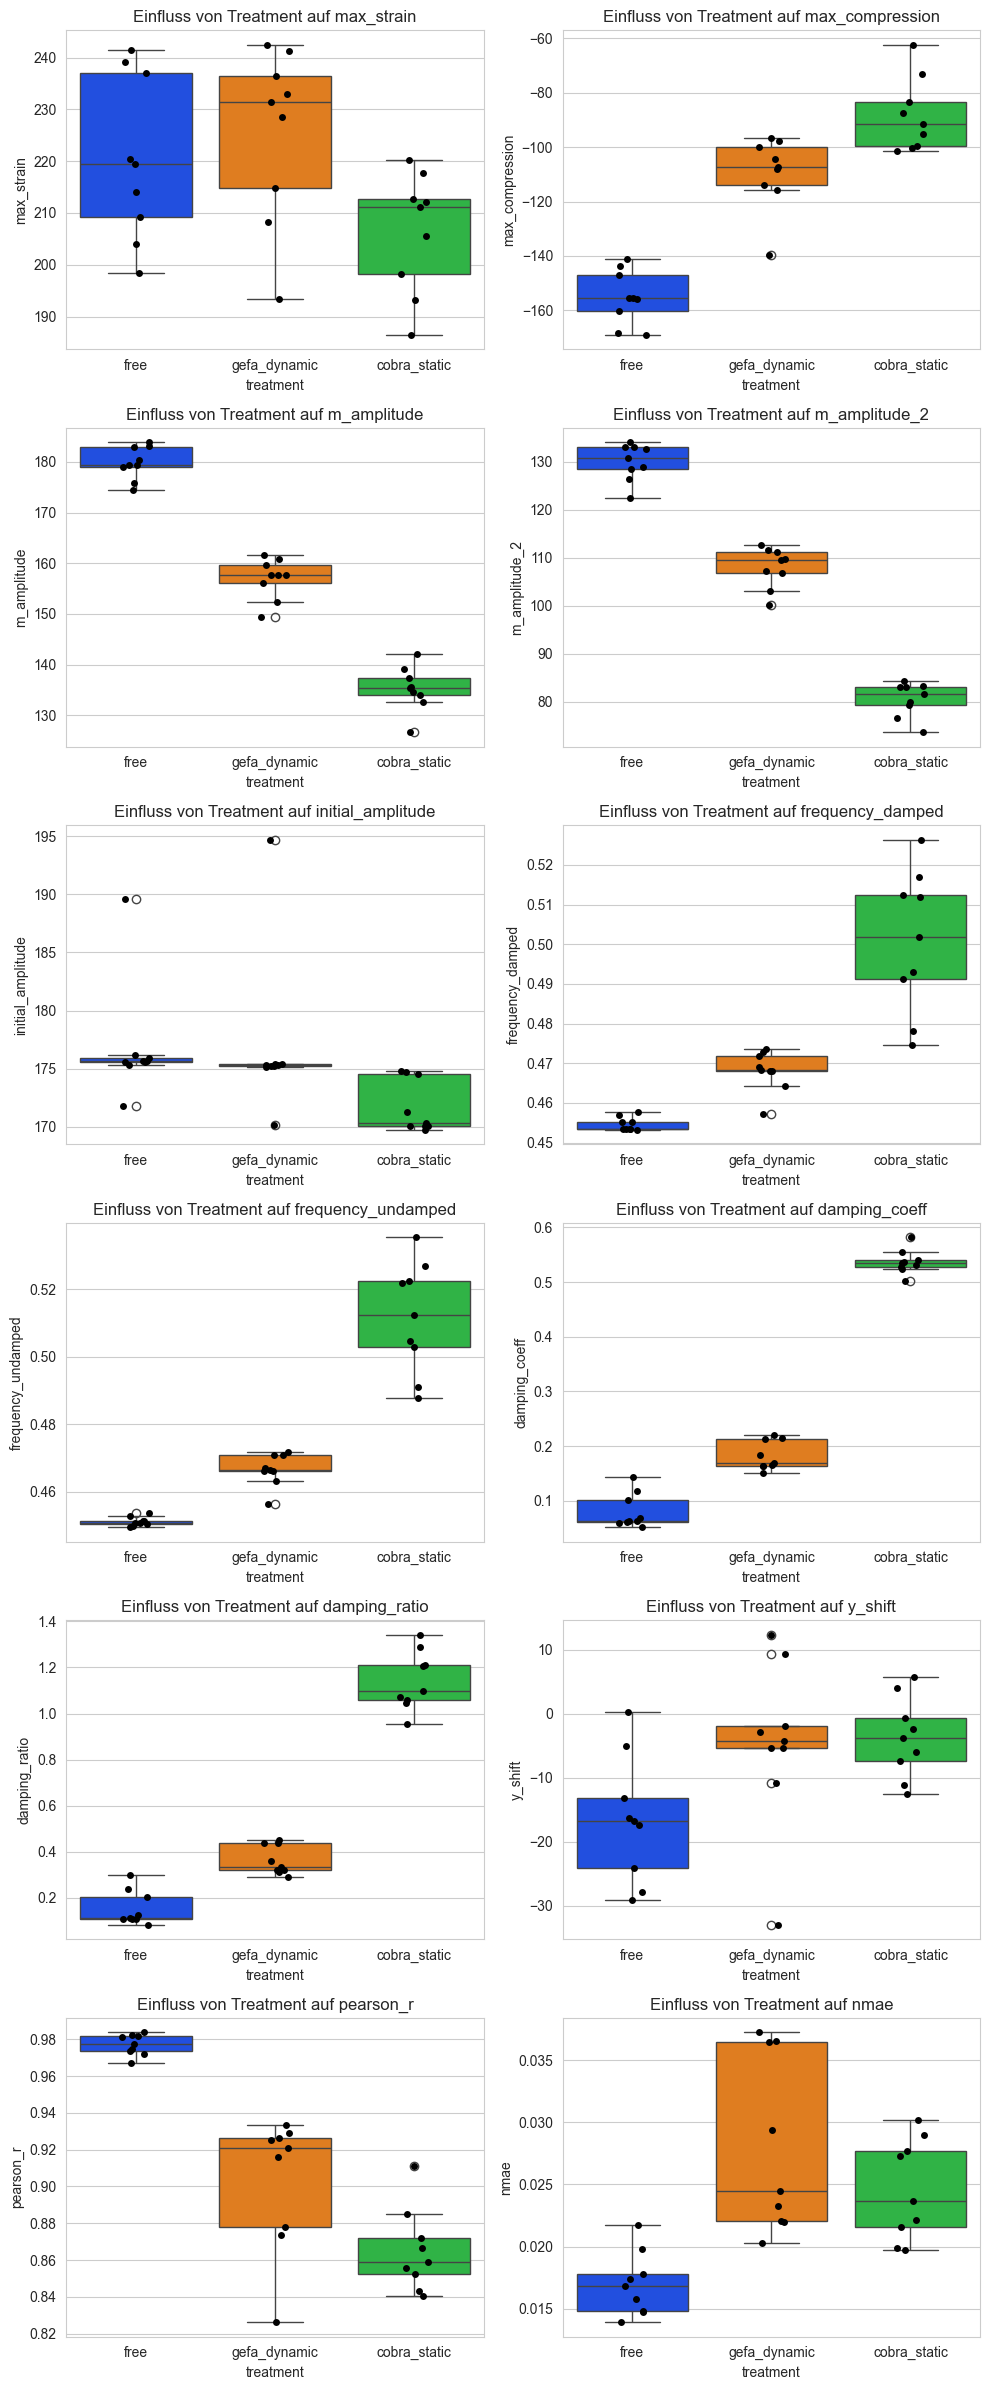

In [81]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables), 2, (len(variables) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables):
    sns.boxplot(ax=axes[i], data=df_adj, x="treatment", y=var, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], data=df_adj, x="treatment", y=var, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="treatment_effect_all_var", subdir="ptq_osc_treatment_effect_sensor_adj")

#### Vorhergesagte Werte extrahieren und Boxplots für die Sensoren erstellen

### Zusammenhangsanalyse für LS3 und PTQ

In [123]:
df_adj.columns

Index(['id', 'treatment', 'rope_release', 'cable_max', 'max_strain',
       'max_compression', 'm_amplitude', 'm_amplitude_2', 'initial_amplitude',
       'frequency_damped', 'frequency_undamped', 'damping_coeff',
       'damping_ratio', 'y_shift', 'pearson_r', 'nmae'],
      dtype='object')

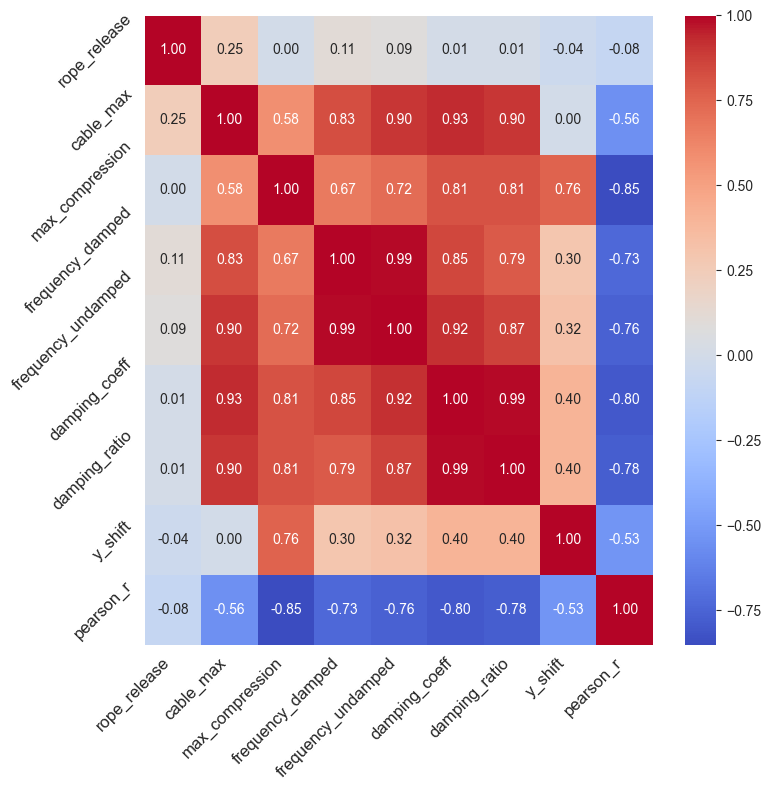

In [125]:
# Auswahl der neuen Spaltennamen für die Korrelationsmatrix
columns_corr = [
    'rope_release', 
    'cable_max', 
    #'max_strain',
    'max_compression', 
    #'m_amplitude', 
    # 'm_amplitude_2', 'initial_amplitude',
    'frequency_damped', 
    'frequency_undamped', 
    'damping_coeff',
    'damping_ratio', 
    'y_shift', 
    'pearson_r', 
    #'nmae'
]

df_corr = df_adj.copy()[columns_corr]

# Berechnung der Korrelationsmatrix
correlation_matrix = df_corr.corr()

# Visualisierung der Korrelationsmatrix mit Seaborn
fig1, ax = plt.subplots(figsize=(8, 8))  # Anpassen der Größe der Grafik
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax, annot_kws={'size': 10})

# Titel und Schriftgrößen anpassen
#plt.title('Correlation Matrix for LS3 and PTQ', fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig1, filename="correlation_matrix", subdir="combined")

#### Zusammenhang Vorspannung und resultierende Lastspitzen

In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude", subdir="combined")


In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude_2'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude_2', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude_2'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude 2')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude 2 [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude_2", subdir="combined")

In [ ]:
# Funktion zur Durchführung des ANOVA-Tests und Berechnung der Effektstärke (Eta Squared)
def perform_anova_and_effect_size(df: pd.DataFrame, variable: str, treatments: List[str]) -> str:
    groups = [df[df['treatment'] == treatment][variable].dropna() for treatment in treatments]
    f_stat, p_value = f_oneway(*groups)

    # Berechnung der Effektstärke (Eta Squared)
    n = sum([len(g) for g in groups])
    ss_total = sum([(x - df[variable].mean()) ** 2 for g in groups for x in g])
    eta_squared = f_stat * len(groups) / (f_stat * len(groups) + (n - len(groups)))

    # Überprüfung der Signifikanz
    significance = "*" if p_value < 0.05 else ""

    return f"{variable}: {significance}\nF-statistic = {f_stat:.2f}\np-value = {p_value:.2e}\nEta Squared = {eta_squared:.2f}"

In [ ]:
# Funktion zur Erstellung von Boxplots
def create_boxplot(df: pd.DataFrame, variable: str, group_by: str, ax: plt.Axes, color_dict: Dict[str, str], perform_stats: bool) -> None:
    valid_df = df.dropna(subset=[variable])
    sns.boxplot(x=group_by, y=variable, hue=group_by, data=valid_df, ax=ax, palette=color_dict, dodge=False)
    ax2 = ax.twinx()
    ax2.axis('off')
    if perform_stats:
        stats_text = perform_anova_and_effect_size(valid_df, variable, valid_df[group_by].unique())
        ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction')
    ax.set_title(f'Einfluss von {group_by} auf {variable}')
    ax.set_xlabel(group_by)
    ax.set_ylabel(variable)

# Funktion zur Erstellung kombinierter Plots
def create_combined_plot(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], num_columns: int = 3, perform_stats: bool = False) -> None:
    num_rows = len(columns) // num_columns + (len(columns) % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 4 * num_rows))
    axes = axes.flatten()

    for idx, variable in enumerate(columns):
        create_boxplot(df, variable, group_by, axes[idx], color_dict, perform_stats)

    plt.tight_layout()
    plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"combined_plot_{group_by}", subdir="combined")

# Funktion zur Erstellung einzelner Plots
def create_individual_plots(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], perform_stats: bool = False) -> None:
    for variable in columns:
        fig, ax = plt.subplots(figsize=(8, 5))
        create_boxplot(df, variable, group_by, ax, color_dict, perform_stats)
        plt.tight_layout()
        #plt.show()
        PLOT_MANAGER.save_plot(fig, filename=f"{group_by}_{variable}", subdir="individual_plots")

In [ ]:
columns = ['ptq_m_amplitude',
           'ptq_m_amplitude_2',
           'ptq_initial_amplitude',
           'ptq_damping_coeff',
           'ptq_angular_frequency',
           'ptq_y_shift',
           'ptq_pearson_r',
           #'ptq_nrmse',
           #'ptq_nmae',
           #'release_force_target',
           'ls3_rope_release',
           'ls3_cable_max'
           ]

# Beispiel: Erstellen von Plots gruppiert nach 'treatment'
create_combined_plot(df, columns, 'treatment', treatment_color_dict, perform_stats=True)
create_individual_plots(df, columns, 'treatment', treatment_color_dict, perform_stats=True)

In [ ]:
# Beispiel: Erstellen von Plots gruppiert nach 'ptq_sensor_name'
columns = ['ptq_m_amplitude', 'ptq_m_amplitude_2', 'ptq_initial_amplitude', 'ptq_damping_coeff', 'ptq_angular_frequency', 'ptq_pearson_r']

create_combined_plot(df, columns, 'ptq_sensor_name', sensor_color_dict)
create_individual_plots(df, columns, 'ptq_sensor_name', sensor_color_dict)